In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder\
    .config("spark.executor.memory", '32g') \
    .config('spark.executor.cores', '2') \
    .config('spark.cores.max', '8') \
    .config("spark.driver.memory",'32g') \
    .config("spark.sql.broadcastTimeout", "1000") \
    .config("spark.driver.maxResultSize", '10g') \
    .getOrCreate()

sc = spark.sparkContext

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
import pandas as pd
from PIL import Image
import numpy as np
import io
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
import os
import pyspark.sql.functions as F
from pyspark.mllib.linalg import Vectors


%matplotlib inline

In [3]:
#Define preprocessing pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler

# load pre-processed table

In [4]:
clean_df = spark.read.load("/project/ds5559/BioNerds/saved_data/clean_indexed.parquet")

In [5]:
clean_df.show(5)

+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+----------+-----------+-----------+------------+
|                path|            features|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|          features_2|indexed_dx|indexed_sex|indexed_loc|indexed_type|
+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+----------+-----------+-----------+------------+
|file:/project/ds5...|[0.69691277, 0.0,...|ISIC_0032827|HAM_0006003|ISIC_0032827|bkl|consensus|85.0|female|lower extremity|[0.69691276550292...|       2.0|        1.0|        1.0|         2.0|
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0032994|HAM_0000772|ISIC_0032994| nv|    histo|20.0|female|           face|[0.0,0.0,0.0,0.0,...|       0.0|        1.0|        5.0|         0.0|
|file:/project/ds5...|[0.0, 0.0, 0.

# load PCA model

In [6]:
pca_path = "/project/ds5559/BioNerds/PCA/pcaModel_50"

In [7]:
%%time
from pyspark.ml.feature import PCAModel
pcaModel_50 = PCAModel.load(pca_path)

CPU times: user 3.64 ms, sys: 2.44 ms, total: 6.08 ms
Wall time: 1.7 s


In [8]:
%%time 
pca_table = pcaModel_50.transform(clean_df)

CPU times: user 2.67 ms, sys: 1.15 ms, total: 3.82 ms
Wall time: 170 ms


In [9]:
pca_table.show(5)

+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+----------+-----------+-----------+------------+--------------------+
|                path|            features|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|          features_2|indexed_dx|indexed_sex|indexed_loc|indexed_type|         pcaFeatures|
+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+----------+-----------+-----------+------------+--------------------+
|file:/project/ds5...|[0.69691277, 0.0,...|ISIC_0032827|HAM_0006003|ISIC_0032827|bkl|consensus|85.0|female|lower extremity|[0.69691276550292...|       2.0|        1.0|        1.0|         2.0|[71.8275654736491...|
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0032994|HAM_0000772|ISIC_0032994| nv|    histo|20.0|female|           face|[0.0,0.0,0.0,0.0,...|

# Model using full size features

In [10]:
vec_assemb = VectorAssembler(inputCols = ['features_2','indexed_loc', 'indexed_sex',"age" ], outputCol = 'Feature_vec')
pipe = Pipeline(stages =  [vec_assemb])

In [11]:
%%time
model_pipe = pipe.fit(clean_df)

CPU times: user 109 µs, sys: 78 µs, total: 187 µs
Wall time: 155 µs


In [12]:
%%time
full_table = model_pipe.transform(pca_table)
full_table.show(5)
full_table.cache()

+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+----------+-----------+-----------+------------+--------------------+--------------------+
|                path|            features|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|          features_2|indexed_dx|indexed_sex|indexed_loc|indexed_type|         pcaFeatures|         Feature_vec|
+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+----------+-----------+-----------+------------+--------------------+--------------------+
|file:/project/ds5...|[0.69691277, 0.0,...|ISIC_0032827|HAM_0006003|ISIC_0032827|bkl|consensus|85.0|female|lower extremity|[0.69691276550292...|       2.0|        1.0|        1.0|         2.0|[71.8275654736491...|(100355,[0,24,70,...|
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0032994|HAM_

DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, features_2: vector, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, pcaFeatures: vector, Feature_vec: vector]

In [13]:
len(full_table.select("features_2").first()[0])

100352

# split full_table to training set and test set by dx.
# using stratified split by ratio 0.8:0.2

In [14]:
full_table.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  514|
|  mel|       1.0| 1111|
|   nv|       0.0| 6650|
|  bkl|       2.0| 1089|
|   df|       6.0|  115|
| vasc|       5.0|  142|
|akiec|       4.0|  327|
+-----+----------+-----+



In [15]:
fractions = full_table.select("dx").distinct().withColumn("fraction", F.lit(0.8)).rdd.collectAsMap()

In [16]:
training_set = full_table.stat.sampleBy("dx",fractions, seed=314)

In [17]:
%%time
training_set.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()
training_set.cache()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  411|
|  mel|       1.0|  890|
|   nv|       0.0| 5336|
|  bkl|       2.0|  865|
|   df|       6.0|   95|
| vasc|       5.0|  111|
|akiec|       4.0|  272|
+-----+----------+-----+

CPU times: user 4.29 ms, sys: 3.19 ms, total: 7.48 ms
Wall time: 12.9 s


DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, features_2: vector, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, pcaFeatures: vector, Feature_vec: vector]

In [18]:
%%time
test_set = full_table.subtract(training_set)
test_set.cache()

CPU times: user 1.69 ms, sys: 752 µs, total: 2.45 ms
Wall time: 176 ms


DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, features_2: vector, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, pcaFeatures: vector, Feature_vec: vector]

In [19]:
training_set1 = training_set.select("indexed_dx", "Feature_vec" )
training_set1.show(5)
training_set1.cache()

+----------+--------------------+
|indexed_dx|         Feature_vec|
+----------+--------------------+
|       2.0|(100355,[0,24,70,...|
|       0.0|(100355,[30,50,75...|
|       3.0|(100355,[14,15,29...|
|       0.0|(100355,[4,30,47,...|
|       2.0|(100355,[47,54,12...|
+----------+--------------------+
only showing top 5 rows



DataFrame[indexed_dx: double, Feature_vec: vector]

In [20]:
test_set1 = test_set.select("indexed_dx", "Feature_vec" )
test_set1.show(5)
test_set1.cache()

+----------+--------------------+
|indexed_dx|         Feature_vec|
+----------+--------------------+
|       0.0|(100355,[75,78,94...|
|       0.0|(100355,[34,35,36...|
|       0.0|(100355,[0,75,101...|
|       0.0|(100355,[0,34,58,...|
|       3.0|(100355,[36,44,51...|
+----------+--------------------+
only showing top 5 rows



DataFrame[indexed_dx: double, Feature_vec: vector]

In [21]:
%%time
mlr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0,  family="multinomial")
mlr.setFeaturesCol("Feature_vec").setThreshold(0.5).setLabelCol("indexed_dx")

fullmodel_mlr = mlr.fit(training_set1)

CPU times: user 29.8 ms, sys: 17 ms, total: 46.8 ms
Wall time: 2min 36s


In [22]:
%%time
predictions =fullmodel_mlr.transform(test_set1)

CPU times: user 7.46 ms, sys: 1.57 ms, total: 9.02 ms
Wall time: 37.7 ms


In [23]:
%%time
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx")
evaluator.evaluate(predictions)

CPU times: user 6.16 ms, sys: 2.65 ms, total: 8.82 ms
Wall time: 15 s


0.7939817996889773

In [24]:
from pyspark.mllib.evaluation import MulticlassMetrics
predictionAndLabels = predictions.select("prediction","indexed_dx")

In [25]:
metrics = MulticlassMetrics(predictionAndLabels.rdd)
metrics.confusionMatrix().toArray()

array([[1.246e+03, 2.900e+01, 2.600e+01, 7.000e+00, 2.000e+00, 4.000e+00,
        0.000e+00],
       [9.000e+01, 9.300e+01, 2.700e+01, 5.000e+00, 5.000e+00, 1.000e+00,
        0.000e+00],
       [6.300e+01, 1.200e+01, 1.400e+02, 7.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00],
       [1.700e+01, 6.000e+00, 1.100e+01, 6.500e+01, 2.000e+00, 2.000e+00,
        0.000e+00],
       [8.000e+00, 3.000e+00, 8.000e+00, 1.300e+01, 2.300e+01, 0.000e+00,
        0.000e+00],
       [1.000e+01, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 1.700e+01,
        0.000e+00],
       [6.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 5.000e+00, 0.000e+00,
        4.000e+00]])

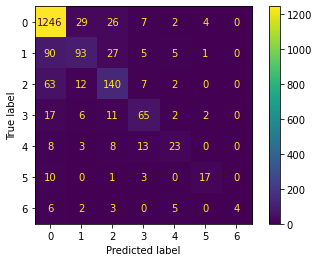

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
ConfusionMatrixDisplay(metrics.confusionMatrix().toArray().astype(int)).plot()

#### accuracy, precision, recall, fMeasure

In [27]:
print("accuracy: {}".format(metrics.accuracy))
print("precision: {}".format(metrics.weightedPrecision))
print("recall: {}".format(metrics.weightedRecall))
print("fMeasure: {}".format(metrics.weightedFMeasure()))

0.806910569105691

In [28]:
### cross valication

#%%time
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(mlr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(mlr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
             .build())

In [29]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=mlr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5, \
                    parallelism = 4)

In [30]:
%%time
cvModel_full = cv.fit(training_set1)

cv_predictions = cvModel_full.transform(test_set1)

CPU times: user 7.13 s, sys: 1.1 s, total: 8.22 s
Wall time: 1h 40min 51s


In [31]:
%%time
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx")
evaluator.evaluate(cv_predictions)

CPU times: user 11.9 ms, sys: 3.18 ms, total: 15.1 ms
Wall time: 9.27 s


0.7929328966942094

In [35]:
bestModel = cvModel_full.bestModel
print ('Best Param (regParam): ', bestModel._java_obj.getRegParam())
print ('Best Param (MaxIter): ', bestModel._java_obj.getMaxIter())
print ('Best Param (elasticNetParam): ', bestModel._java_obj.getElasticNetParam())

Best Param (regParam):  0.5
Best Param (MaxIter):  20
Best Param (elasticNetParam):  0.0


In [32]:
cv_predictionAndLabels = cv_predictions.select("prediction","indexed_dx")
cv_metrics = MulticlassMetrics(cv_predictionAndLabels.rdd)
cv_metrics.confusionMatrix().toArray()

array([[1.254e+03, 2.800e+01, 2.200e+01, 5.000e+00, 1.000e+00, 4.000e+00,
        0.000e+00],
       [8.700e+01, 9.000e+01, 3.200e+01, 1.000e+00, 9.000e+00, 2.000e+00,
        0.000e+00],
       [6.000e+01, 1.300e+01, 1.380e+02, 5.000e+00, 8.000e+00, 0.000e+00,
        0.000e+00],
       [1.600e+01, 5.000e+00, 1.600e+01, 5.300e+01, 1.000e+01, 3.000e+00,
        0.000e+00],
       [9.000e+00, 2.000e+00, 1.000e+01, 5.000e+00, 2.900e+01, 0.000e+00,
        0.000e+00],
       [1.000e+01, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 1.800e+01,
        0.000e+00],
       [6.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 5.000e+00, 0.000e+00,
        4.000e+00]])

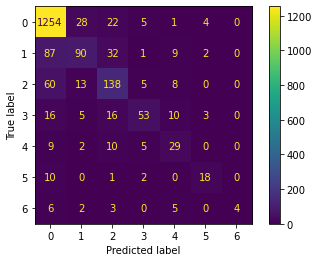

In [33]:
ConfusionMatrixDisplay(cv_metrics.confusionMatrix().toArray().astype(int)).plot()

In [34]:
cv_metrics.accuracy

0.8058943089430894

# Model using PCA top 50
## assemble features. 

In [10]:
from pyspark.ml.feature import OneHotEncoder


#Define preprocessing pipeline

#OneHot encode variables
OH = OneHotEncoder(inputCols = ['indexed_sex', 'indexed_loc'], outputCols = ['OH_sex', 'OH_loc'])

#Assemble Features vector
vec_assemb = VectorAssembler(inputCols = ['age', 'OH_sex', 'OH_loc', 'pcaFeatures'], \
                             outputCol = 'Feature_vec', handleInvalid = 'skip')

mlr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0,  family="multinomial", probabilityCol = 'probability')
mlr.setFeaturesCol("Feature_vec").setThreshold(0.5).setLabelCol("indexed_dx")

LogisticRegression_1a80889d6e4a

In [11]:
model_pipe = Pipeline(stages = [ OH, vec_assemb, mlr])

In [12]:
# save dataframe
# transformed_table.write.save("/project/ds5559/BioNerds/saved_data/transformed_table.parquet")

# split transformed_table to training set and test set by dx. 
# using stratified split by ratio 0.8:0.2

In [13]:
pca_table.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  514|
|  mel|       1.0| 1111|
|   nv|       0.0| 6650|
|  bkl|       2.0| 1089|
|   df|       6.0|  115|
| vasc|       5.0|  142|
|akiec|       4.0|  327|
+-----+----------+-----+



In [14]:
fractions = pca_table.select("dx").distinct().withColumn("fraction", F.lit(0.8)).rdd.collectAsMap()
fractions

{'vasc': 0.8,
 'nv': 0.8,
 'mel': 0.8,
 'bcc': 0.8,
 'df': 0.8,
 'bkl': 0.8,
 'akiec': 0.8}

In [15]:
training_set = pca_table.stat.sampleBy("dx",fractions, seed=314)

In [16]:
%%time
training_set.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()
training_set.cache()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  411|
|  mel|       1.0|  890|
|   nv|       0.0| 5336|
|  bkl|       2.0|  865|
|   df|       6.0|   95|
| vasc|       5.0|  111|
|akiec|       4.0|  272|
+-----+----------+-----+

CPU times: user 3.73 ms, sys: 2.12 ms, total: 5.86 ms
Wall time: 936 ms


DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, features_2: vector, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, pcaFeatures: vector]

In [17]:
%%time
test_set = pca_table.subtract(training_set)
test_set.cache()

CPU times: user 1.81 ms, sys: 541 µs, total: 2.35 ms
Wall time: 208 ms


DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, features_2: vector, indexed_dx: double, indexed_sex: double, indexed_loc: double, indexed_type: double, pcaFeatures: vector]

In [18]:
%%time
test_set.select("dx", "indexed_dx").groupby("dx","indexed_dx").count().show()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  103|
|  mel|       1.0|  221|
|   nv|       0.0| 1314|
|  bkl|       2.0|  224|
|   df|       6.0|   20|
| vasc|       5.0|   31|
|akiec|       4.0|   55|
+-----+----------+-----+

CPU times: user 18.4 ms, sys: 11.4 ms, total: 29.8 ms
Wall time: 2min 43s


# fit logistic Regression Model

In [20]:
# Model with age, sex, localization, age, dx_type

In [21]:
%%time
model_mlr = model_pipe.fit(training_set)

CPU times: user 24.6 ms, sys: 6.21 ms, total: 30.9 ms
Wall time: 20.2 s


In [22]:
%%time
predictions =model_mlr.transform(test_set)

CPU times: user 8.11 ms, sys: 5.07 ms, total: 13.2 ms
Wall time: 94.1 ms


In [23]:
%%time
predictions.show(10)

+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+------------+--------------------+----------+-----------+-----------+------------+--------------------+-------------+---------------+--------------------+--------------------+--------------------+----------+
|                path|            features|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|localization|          features_2|indexed_dx|indexed_sex|indexed_loc|indexed_type|         pcaFeatures|       OH_sex|         OH_loc|         Feature_vec|       rawPrediction|         probability|prediction|
+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+------------+--------------------+----------+-----------+-----------+------------+--------------------+-------------+---------------+--------------------+--------------------+--------------------+----------+
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0027826

In [24]:
%%time
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx")
evaluator.evaluate(predictions)

CPU times: user 6.74 ms, sys: 3.47 ms, total: 10.2 ms
Wall time: 3.88 s


0.6092675881197551

In [25]:
from pyspark.mllib.evaluation import MulticlassMetrics
predictionAndLabels = predictions.select("prediction","indexed_dx")

In [26]:
predictionAndLabels.show(5)

+----------+----------+
|prediction|indexed_dx|
+----------+----------+
|       2.0|       2.0|
|       0.0|       0.0|
|       0.0|       1.0|
|       0.0|       0.0|
|       0.0|       0.0|
+----------+----------+
only showing top 5 rows



In [27]:
metrics = MulticlassMetrics(predictionAndLabels.rdd)
metrics.confusionMatrix().toArray()

array([[1.313e+03, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.950e+02, 1.800e+01, 8.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.700e+02, 2.000e+00, 5.200e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00],
       [8.300e+01, 5.000e+00, 1.400e+01, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00],
       [4.100e+01, 1.000e+00, 1.300e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.800e+01, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.900e+01, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]])

### confusion matrix

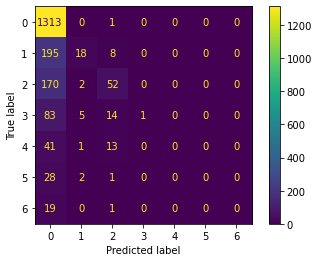

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
ConfusionMatrixDisplay(metrics.confusionMatrix().toArray().astype(int)).plot()

### accuracy

In [29]:
print("accuracy: {}".format(metrics.accuracy))
print("precision: {}".format(metrics.weightedPrecision))
print("recall: {}".format(metrics.weightedRecall))
print("fMeasure: {}".format(metrics.weightedFMeasure()))

accuracy: 0.7032520325203252
precision: 0.664422199298418
recall: 0.7032520325203251
fMeasure: 0.6092675881197551


### Statistics by class

In [29]:
labels = predictionAndLabels.rdd.map(lambda lp: lp.indexed_dx).distinct().collect()
df = pd.DataFrame()
for label in sorted(labels):
    df = df.append({"class": label, 
               "precision":metrics.precision(label),
               "recall":metrics.recall(label),
               "f1":metrics.fMeasure(label),
              }, ignore_index=True)
df

,class,f1,precision,recall
0,0.0,0.830224,0.710114,0.999239
1,1.0,0.144578,0.642857,0.081448
2,2.0,0.331210,0.577778,0.232143
3,3.0,0.019231,1.000000,0.009709
4,4.0,0.000000,0.000000,0.000000
5,5.0,0.000000,0.000000,0.000000
6,6.0,0.000000,0.000000,0.000000


# Cross Validation (5 fold) and Tuning hyperparameters

In [30]:
### cross valication

#%%time
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(mlr.regParam, [0, 0.1, 0.2, 0.3, 0.4, 0.5]) # regularization parameter
             .addGrid(mlr.elasticNetParam, [0.0, 0.1, 0.2, 0.3, 0.4]) # Elastic Net Parameter (Ridge = 0)
             .build())

In [31]:
%%time
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=model_pipe, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5, \
                    parallelism = 4, \
                    seed = 314)

CPU times: user 406 µs, sys: 0 ns, total: 406 µs
Wall time: 328 µs


In [49]:
%%time
cvModel = cv.fit(training_set)

cv_predictions = cvModel.transform(test_set)

CPU times: user 7.03 s, sys: 2.07 s, total: 9.1 s
Wall time: 23min 20s


In [34]:
%%time
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx")
evaluator.evaluate(cv_predictions)

CPU times: user 4.37 ms, sys: 2.35 ms, total: 6.71 ms
Wall time: 3.17 s


0.7818560513162651

In [51]:
bestModel = cvModel.bestModel
print ('Best Param (regParam): ', bestModel.stages[2].getRegParam())
print ('Best Param (MaxIter): ', bestModel.stages[2].getMaxIter())
print ('Best Param (elasticNetParam): ', bestModel.stages[2].getElasticNetParam())

Best Param (regParam):  0.0
Best Param (MaxIter):  20
Best Param (elasticNetParam):  0.0


In [35]:
cv_predictionAndLabels = cv_predictions.select("prediction","indexed_dx")
preds_and_probs = cv_predictions.select(['indexed_dx', 'probability', 'prediction'])


cv_metrics = MulticlassMetrics(cv_predictionAndLabels.rdd)
cv_metrics.confusionMatrix().toArray()

array([[1.253e+03, 3.100e+01, 2.200e+01, 7.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00],
       [9.500e+01, 8.600e+01, 2.000e+01, 7.000e+00, 9.000e+00, 4.000e+00,
        0.000e+00],
       [6.400e+01, 2.700e+01, 1.130e+02, 7.000e+00, 1.200e+01, 0.000e+00,
        1.000e+00],
       [9.000e+00, 3.000e+00, 1.700e+01, 6.000e+01, 9.000e+00, 2.000e+00,
        3.000e+00],
       [8.000e+00, 3.000e+00, 9.000e+00, 9.000e+00, 2.600e+01, 0.000e+00,
        0.000e+00],
       [8.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 1.900e+01,
        0.000e+00],
       [4.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 5.000e+00, 0.000e+00,
        7.000e+00]])

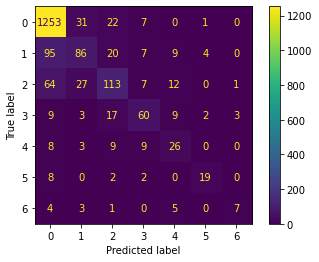

In [36]:
ConfusionMatrixDisplay(cv_metrics.confusionMatrix().toArray().astype(int)).plot()

#### accuracy, precision, recall, fMeasure

In [37]:
print("accuracy: {}".format(cv_metrics.accuracy))
print("precision: {}".format(cv_metrics.weightedPrecision))
print("recall: {}".format(cv_metrics.weightedRecall))
print("fMeasure: {}".format(cv_metrics.weightedFMeasure()))

accuracy: 0.7947154471544715
precision: 0.7776189754879486
recall: 0.7947154471544715
fMeasure: 0.7818560513162651


### Statistics by class

In [38]:
labels = cv_predictionAndLabels.rdd.map(lambda lp: lp.indexed_dx).distinct().collect()
cv_df = pd.DataFrame()
for label in sorted(labels):
    cv_df = cv_df.append({"class": label, 
               "precision":cv_metrics.precision(label),
               "recall":cv_metrics.recall(label),
               "f1":cv_metrics.fMeasure(label),
              }, ignore_index=True)
cv_df

,class,f1,precision,recall
0,0.0,0.909619,0.869535,0.953577
1,1.0,0.459893,0.562092,0.389140
2,2.0,0.553922,0.614130,0.504464
3,3.0,0.615385,0.652174,0.582524
4,4.0,0.448276,0.426230,0.472727
5,5.0,0.666667,0.730769,0.612903
6,6.0,0.451613,0.636364,0.350000


### ROC

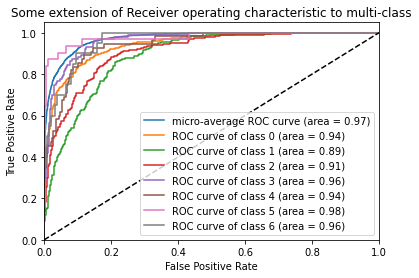

In [40]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

#y_test = list(cv_predictionAndLabels.select('indexed_dx').toPandas()['indexed_dx'])
#y_score = list(cv_predictionAndLabels.select('prediction').toPandas()['prediction'])
#y_test = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6])
#y_score = label_binarize(y_score, classes=[0, 1, 2,3,4,5,6])


y_test = list(preds_and_probs.select('indexed_dx').toPandas()['indexed_dx'])
y_score = np.array(list(preds_and_probs.select('probability').toPandas()['probability']))
y_test = label_binarize(y_test, classes=[0,1,2,3,4,5,6])
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()